# Auto Encoder

## Load Dataset

In [1]:
DATASET_NAME = 'dataset-5000'
TEST_DATASET_NAME = 'dataset-test'
BATCH_SIZE = 16
MODEL_PATH = 'model/cnn_dropout'

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from util import GeneratedDataset

trainset = GeneratedDataset(DATASET_NAME, transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = GeneratedDataset(TEST_DATASET_NAME, transforms.ToTensor())
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

## Define CNN based auto-encoder

- 64 * 64 * 3 image input = 12,288
- Cov3 with 32 channel, 3 * 3 * 3 * 32 = 864 parameters
- ReLU
- MaxPool -> 32 * 32 * 32 hidden state = 32768
- Cov3 with 64 channel, 32 * 3 * 3 * 64 = 18432 parameters
- ReLU
- MaxPool -> 16 * 16 * 64 hidden state = 16384
- Cov3 with 128 channel, 64 * 3 * 3 * 128 = 73728 parameters
- ReLU
- MaxPool -> 8 * 8 * 128 = 8192 hidden state
- Full connected 8192 -> **embedding size**

And the decoder works reversely.

In [2]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, embedding_size=32, dropout_rate=0.25):
        super(Autoencoder, self).__init__()
        self.embedding_size = embedding_size
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(dropout_rate),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(dropout_rate),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(dropout_rate),
        )
        self.fc1 = nn.Linear(8 * 8 * 128, self.embedding_size)  # Fully connected layer to get 32-length embedding

        # Decoder
        self.fc2 = nn.Linear(self.embedding_size, 8 * 8 * 128)  # Fully connected layer to reshape back to 8x8x128
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)  # Flatten the tensor
        encoded = self.fc1(encoded)  # Get the embedding
        decoded = self.fc2(encoded)  # Reshape back to 8x8x128
        decoded = decoded.view(decoded.size(0), 128, 8, 8)
        decoded = self.decoder(decoded)
        return decoded, encoded

In [3]:
from util import calc_and_plot_metrics, fit_nearest_neighbor, train_model_steps, plot_model, count_parameters, save_to_file, load_from_file

accuracy = {}

def train_model(embedding_size=32, dropout_rate=0.25, learning_rate=1e-4, weight_decay=1e-5, num_epochs=20):
    # Initialize the model
    model = Autoencoder(embedding_size=embedding_size, dropout_rate=dropout_rate)
    print(f'Number of parameters: {count_parameters(model)}')

    model_path = f'{MODEL_PATH}/e{embedding_size}.pth'
    stat_path = f'{MODEL_PATH}/e{embedding_size}.pkl'
    if os.path.exists(model_path) and os.path.exists(stat_path):
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        train_losses, test_losses = load_from_file(stat_path)
    else:
        model, train_losses, test_losses = train_model_steps(model, trainloader, testloader, learning_rate, weight_decay, num_epochs)
        # Save the model
        torch.save(model.state_dict(), model_path)
        save_to_file((train_losses, test_losses), stat_path)

    acc = fit_nearest_neighbor(model)
    accuracy[embedding_size] = acc
    calc_and_plot_metrics(model, testset)
    plot_model(model, train_losses, test_losses, testset)
    return model, train_losses, test_losses

## Evaluation

Testing with embedding size of (down from 8192)
- 4
- 8
- 16
- 32
- 64

Number of parameters: 407687


/Users/criyle/project/cse5524/cse5524final/util.py:333: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:334: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.215
Shape Accuracy: 0.718
Combined Accuracy: 0.158


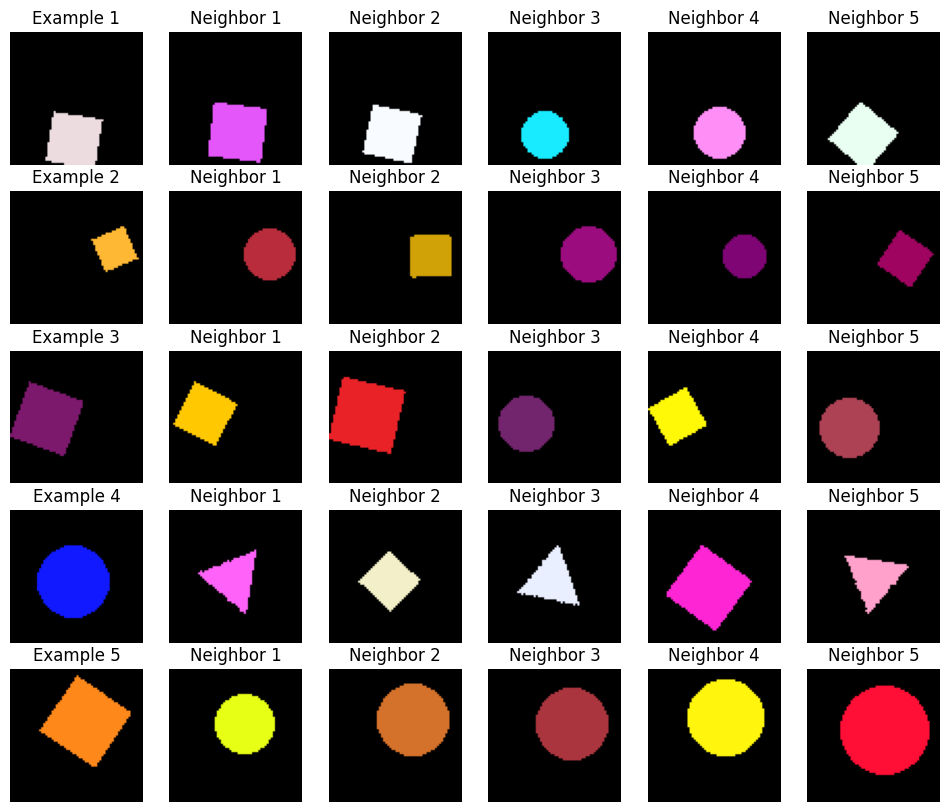

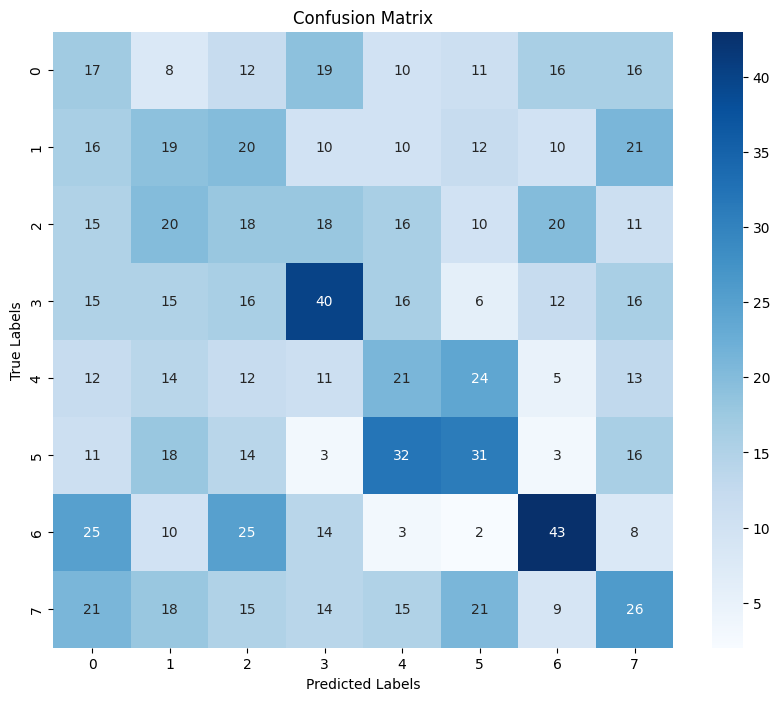

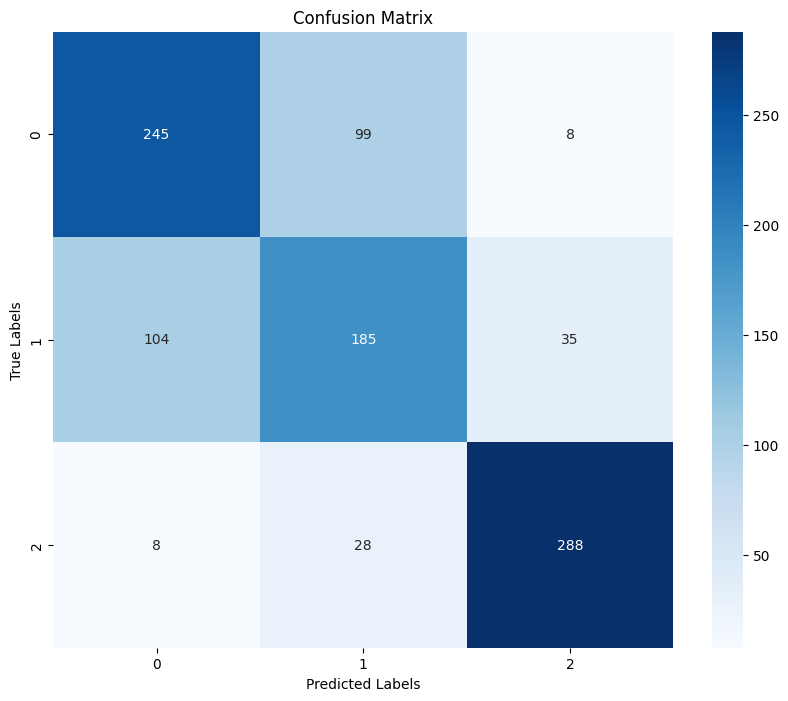

Silhouette Score: -0.19786541163921356
Cluster Purity: 0.188
Normalized Mutual Information (NMI): 0.2456679229945789


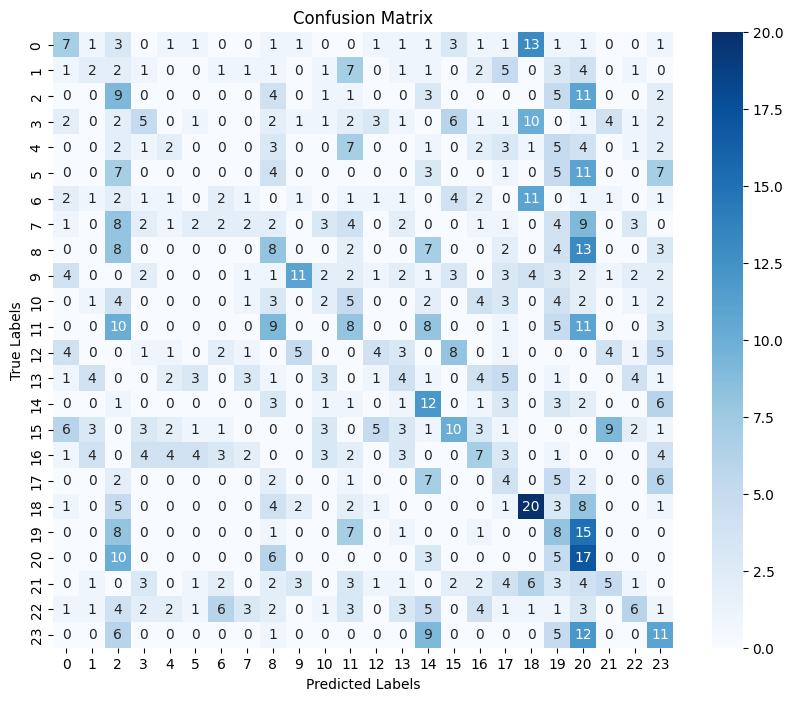

Silhouette Score: -0.13882358372211456
Cluster Purity: 0.241
Normalized Mutual Information (NMI): 0.08033548452671874


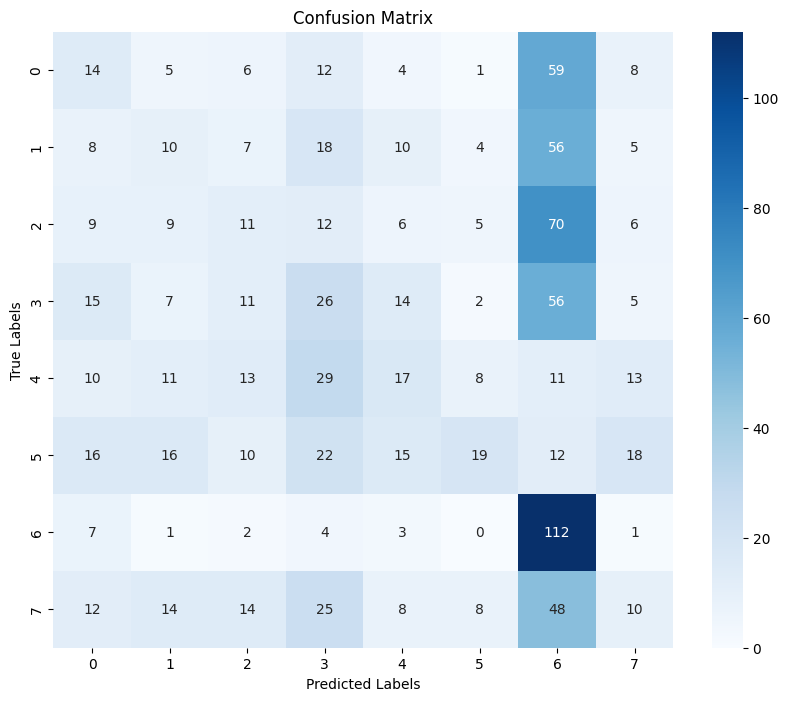

Silhouette Score: 0.024026762694120407
Cluster Purity: 0.514
Normalized Mutual Information (NMI): 0.13939980051716153


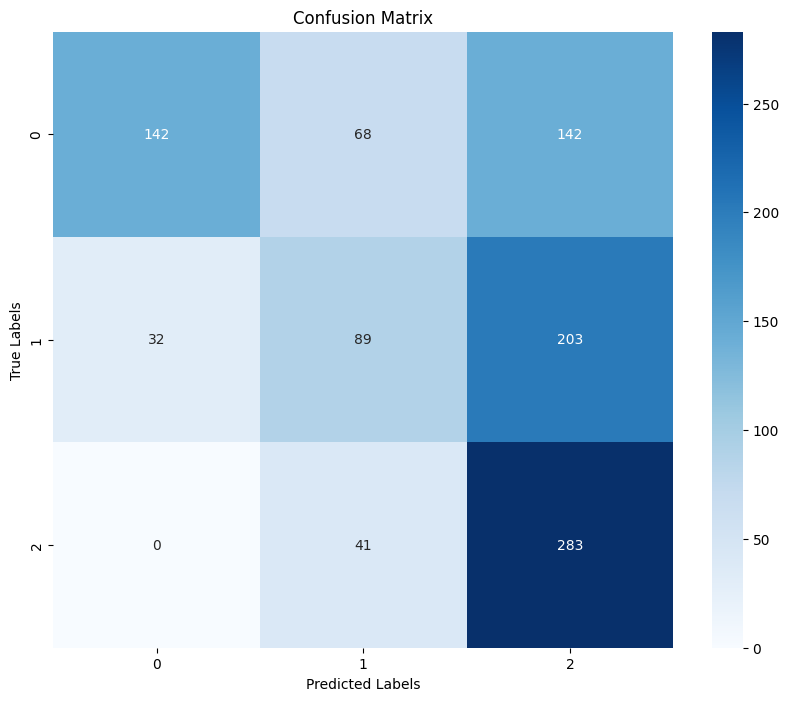

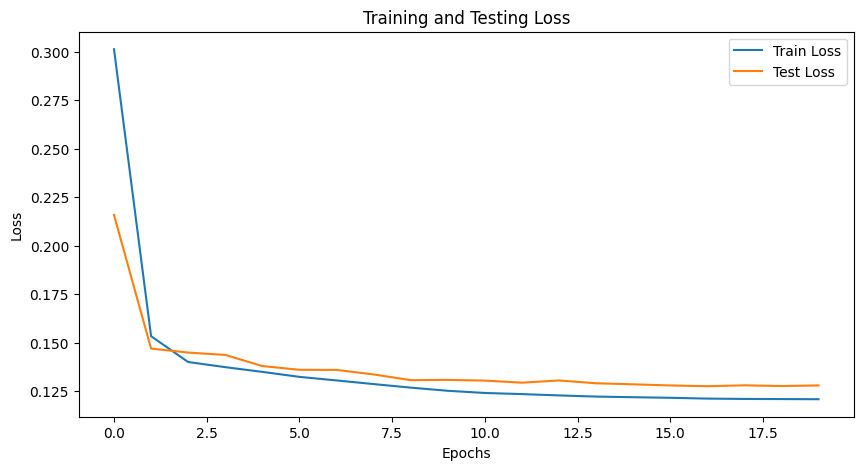

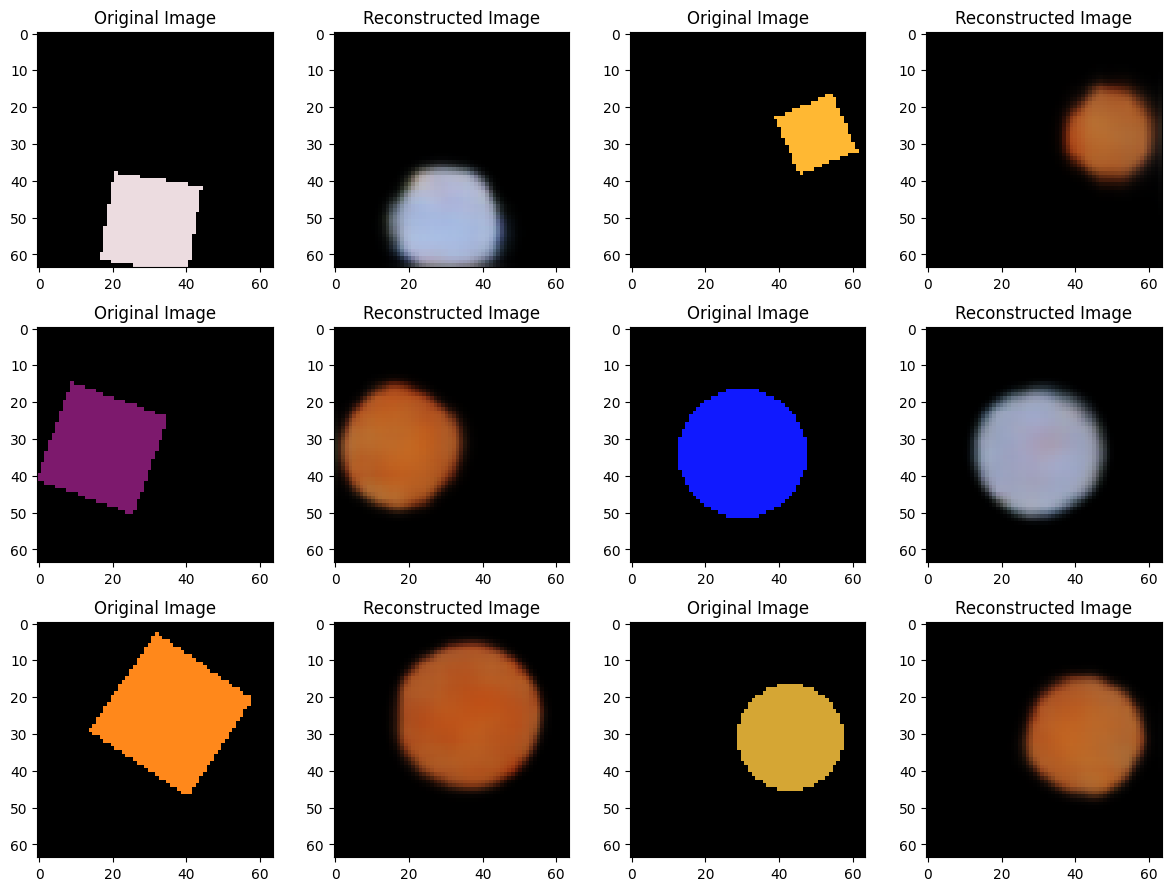

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Dropout(p=0.1, inplace=False)
     (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (5): ReLU()
     (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (7): Dropout(p=0.1, inplace=False)
     (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (9): ReLU()
     (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (11): Dropout(p=0.1, inplace=False)
   )
   (fc1): Linear(in_features=8192, out_features=4, bias=True)
   (fc2): Linear(in_features=4, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')
 

In [4]:
train_model(embedding_size=4, dropout_rate=0.1)

Number of parameters: 473227


/Users/criyle/project/cse5524/cse5524final/util.py:333: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:334: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.32
Shape Accuracy: 0.708
Combined Accuracy: 0.218


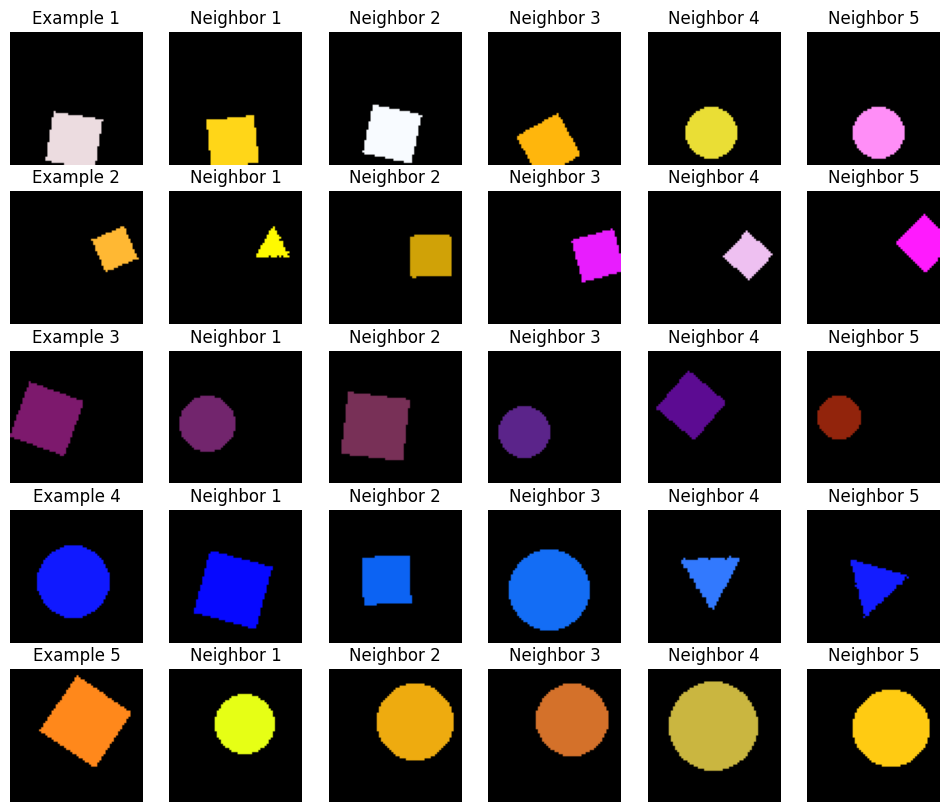

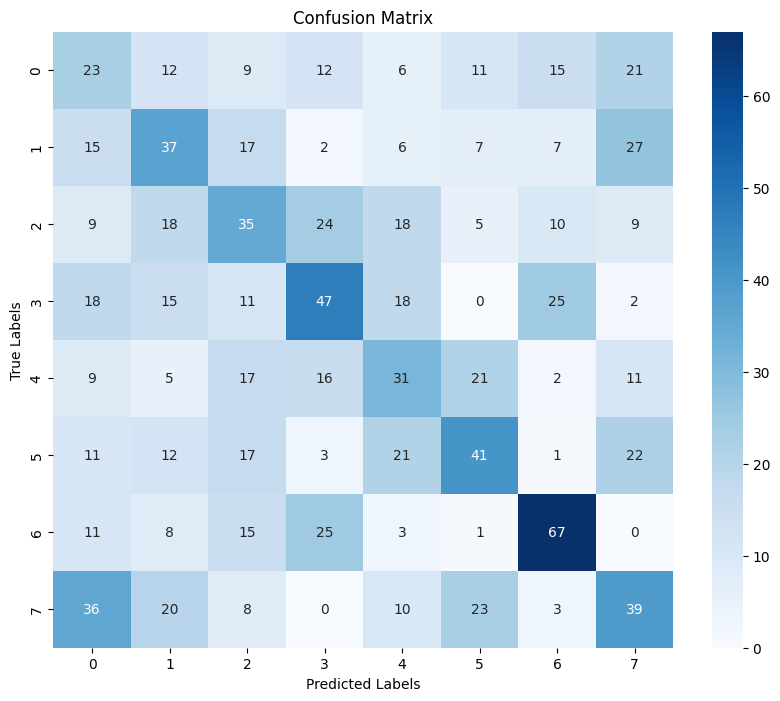

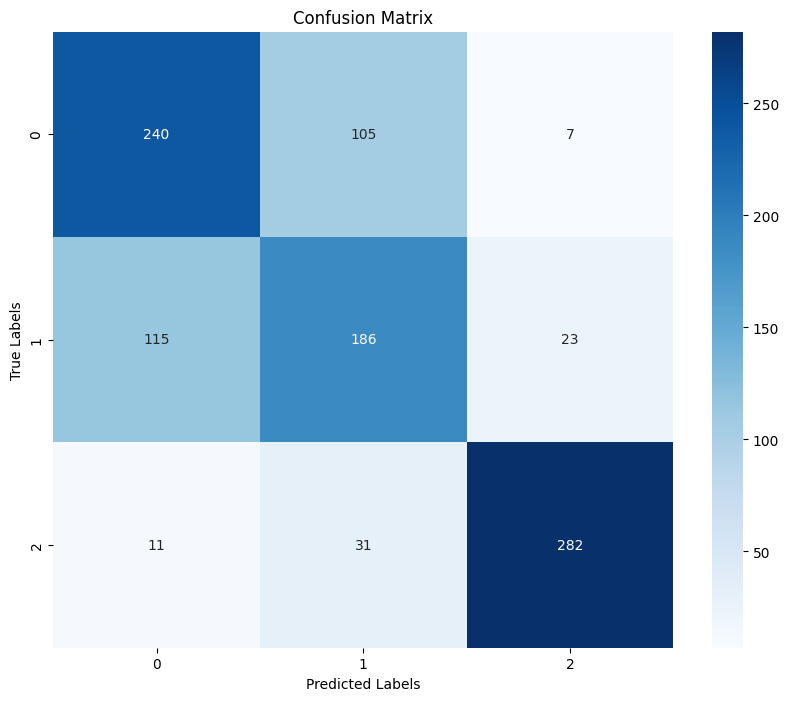

Silhouette Score: -0.1806333065032959
Cluster Purity: 0.202
Normalized Mutual Information (NMI): 0.27251107545190206


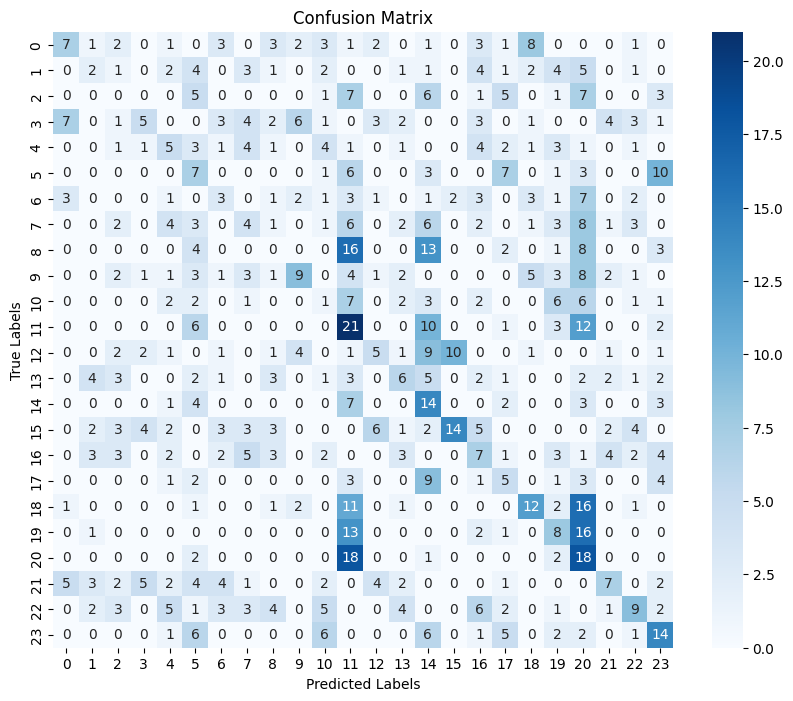

Silhouette Score: -0.1253598928451538
Cluster Purity: 0.265
Normalized Mutual Information (NMI): 0.1085048624344685


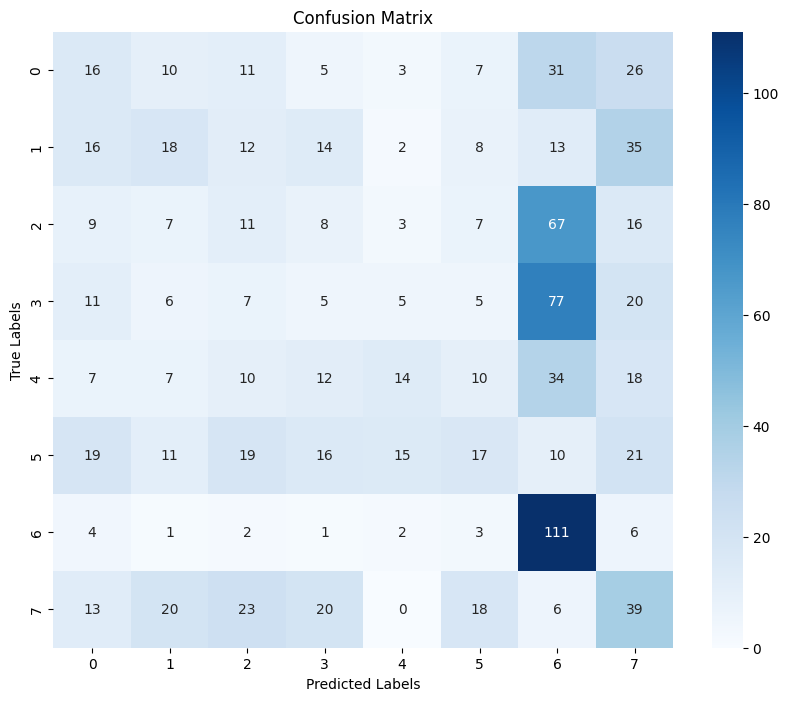

Silhouette Score: 0.011343562975525856
Cluster Purity: 0.472
Normalized Mutual Information (NMI): 0.13095097836172045


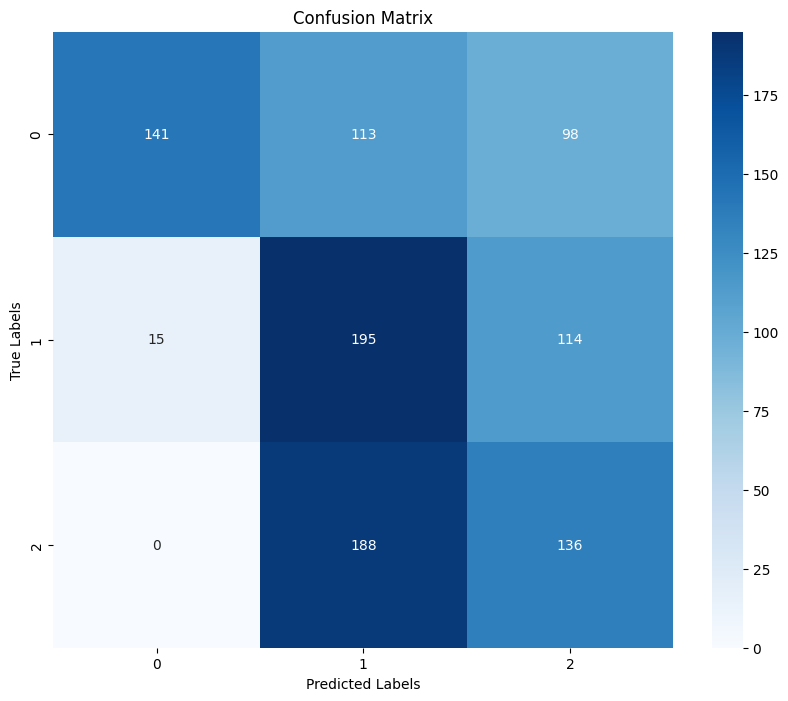

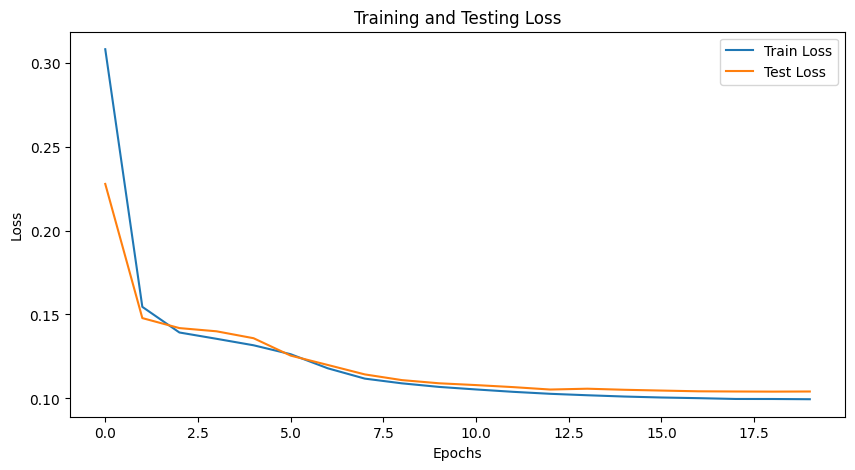

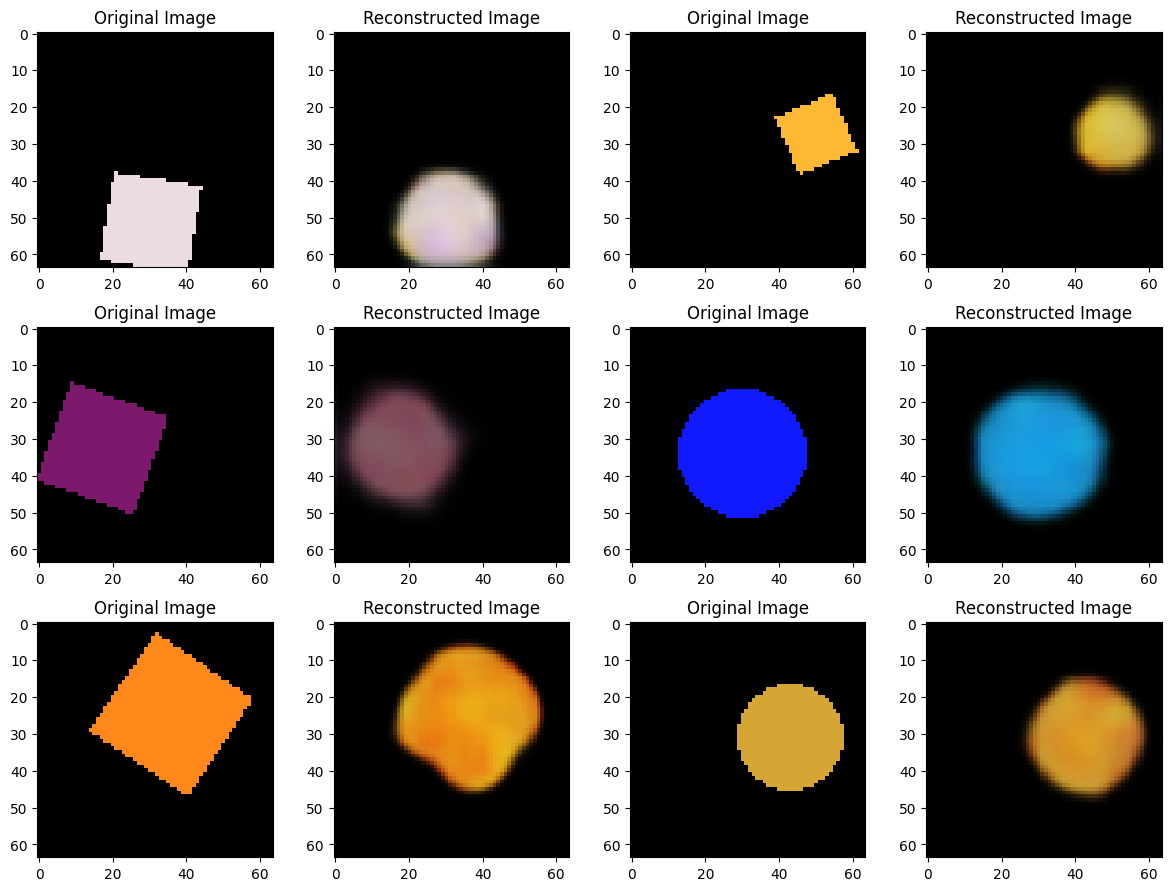

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Dropout(p=0.1, inplace=False)
     (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (5): ReLU()
     (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (7): Dropout(p=0.1, inplace=False)
     (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (9): ReLU()
     (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (11): Dropout(p=0.1, inplace=False)
   )
   (fc1): Linear(in_features=8192, out_features=8, bias=True)
   (fc2): Linear(in_features=8, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')
 

In [5]:
train_model(embedding_size=8, dropout_rate=0.1)

Number of parameters: 604307


/Users/criyle/project/cse5524/cse5524final/util.py:333: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:334: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.298
Shape Accuracy: 0.715
Combined Accuracy: 0.207


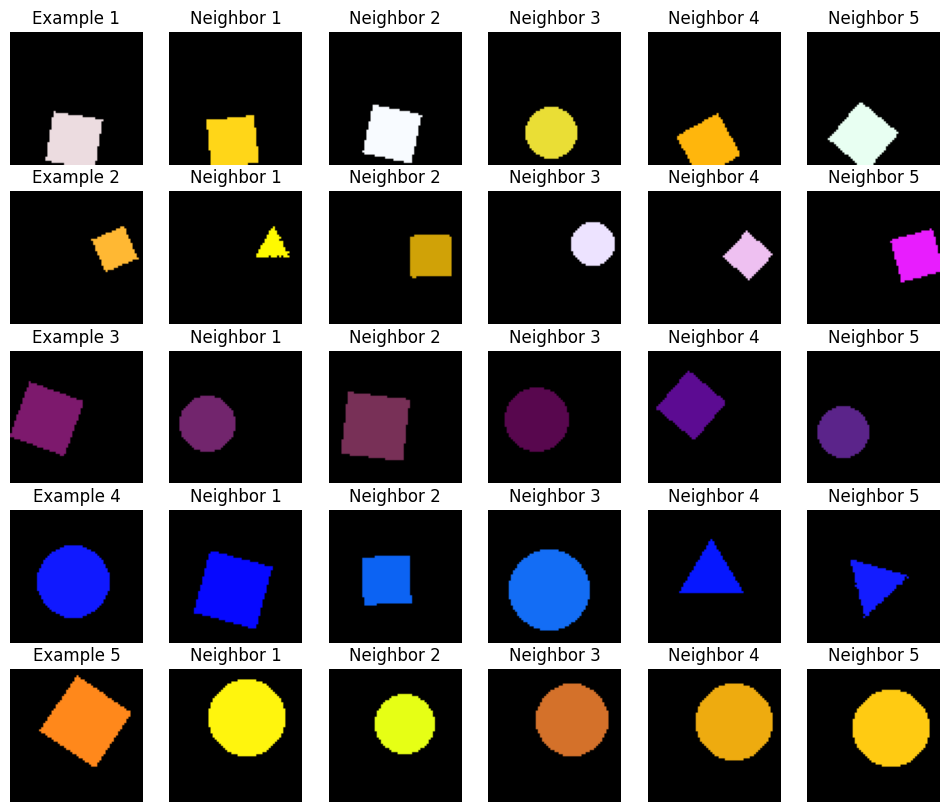

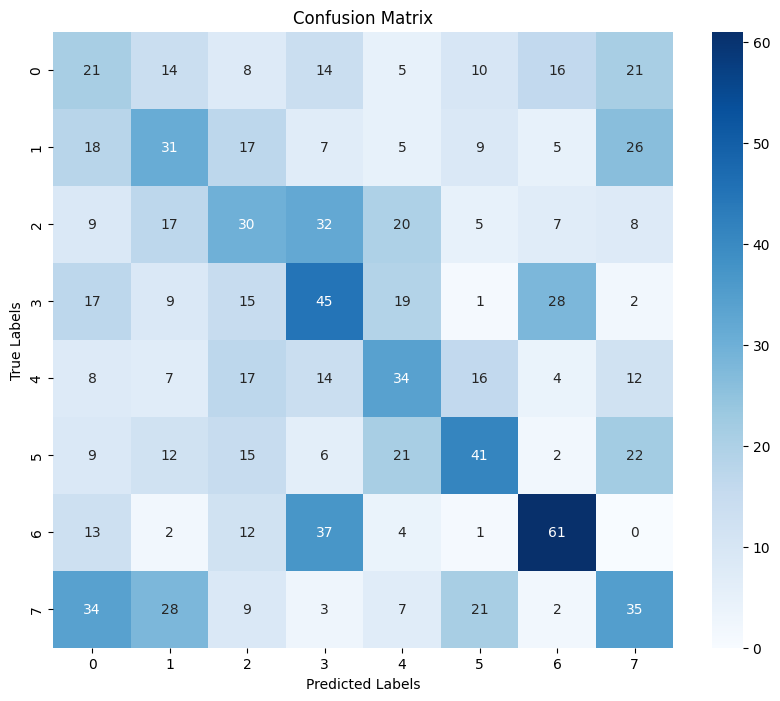

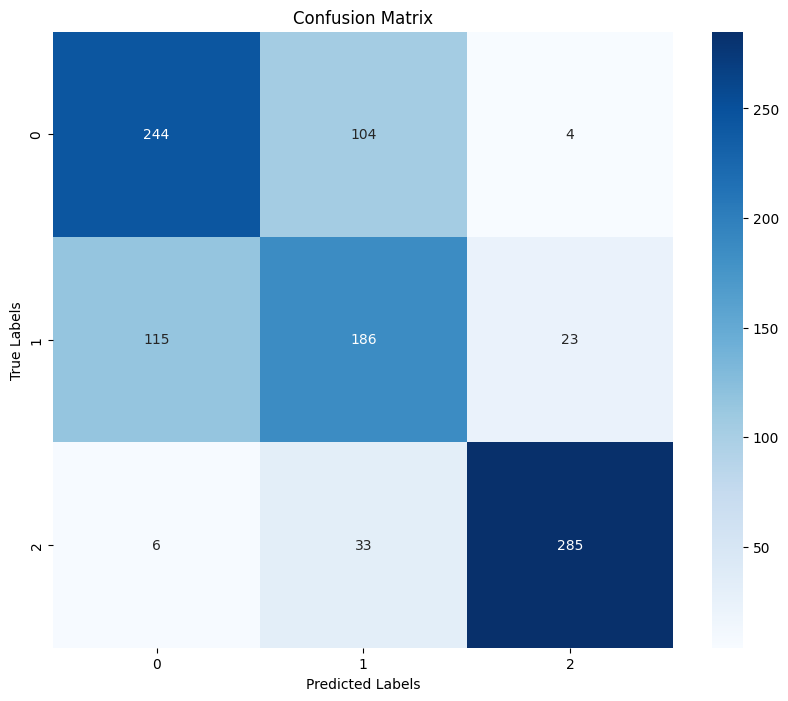

Silhouette Score: -0.15798793733119965
Cluster Purity: 0.207
Normalized Mutual Information (NMI): 0.2637982295215844


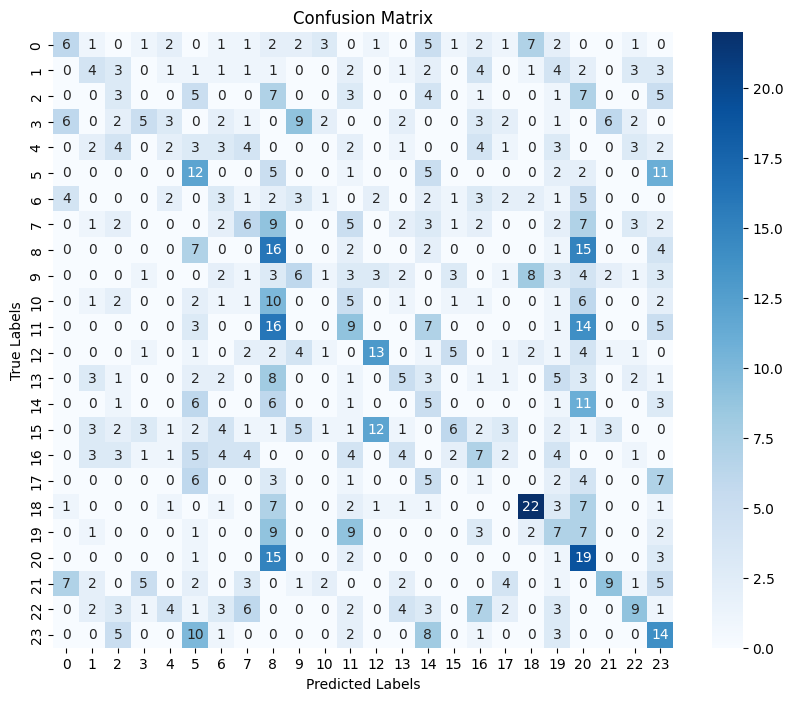

Silhouette Score: -0.10908561199903488
Cluster Purity: 0.247
Normalized Mutual Information (NMI): 0.07743515118991878


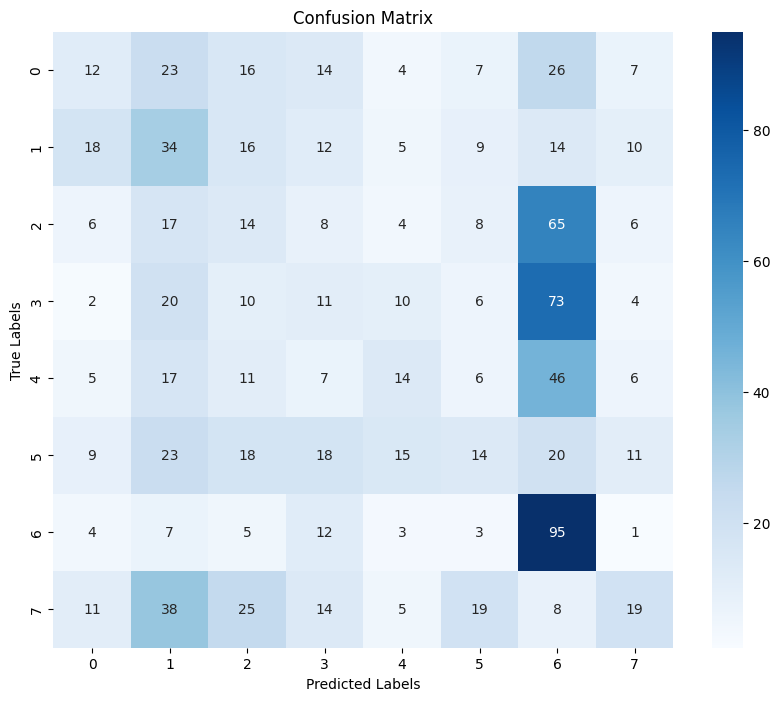

Silhouette Score: 0.01433571893721819
Cluster Purity: 0.499
Normalized Mutual Information (NMI): 0.1429147466283123


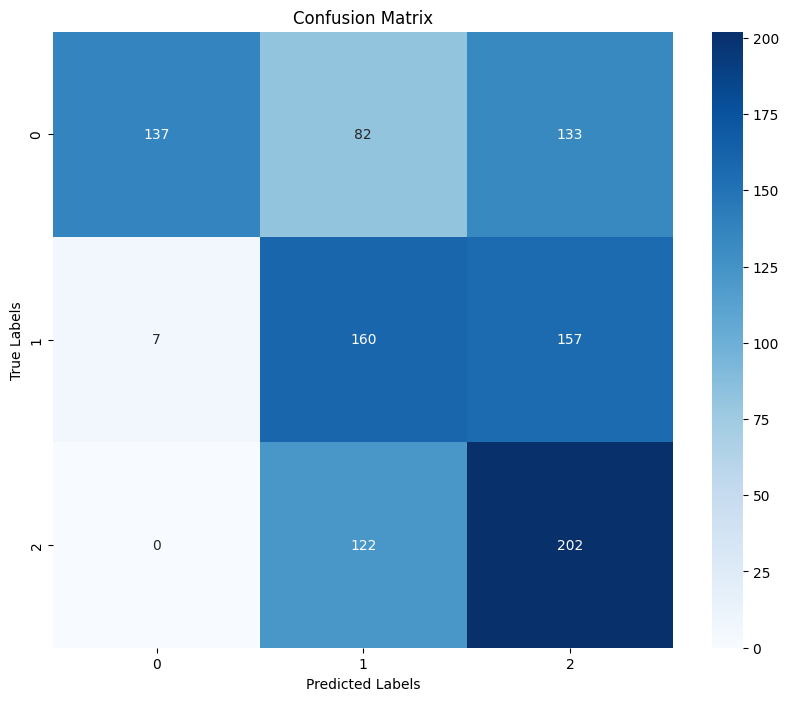

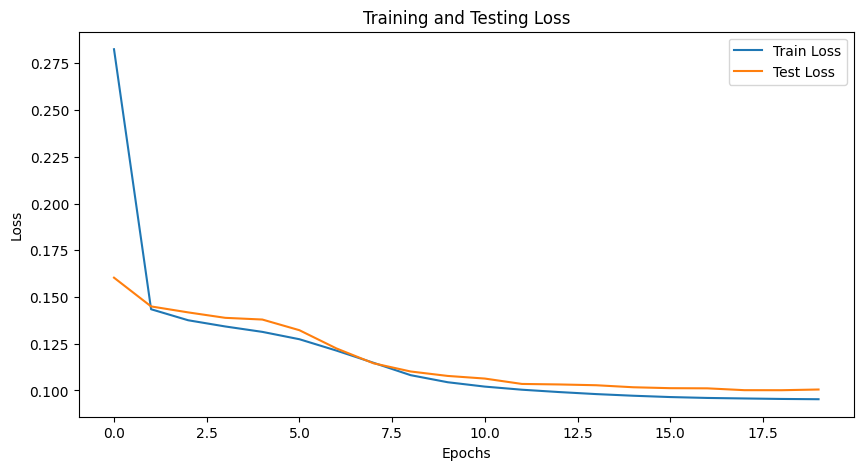

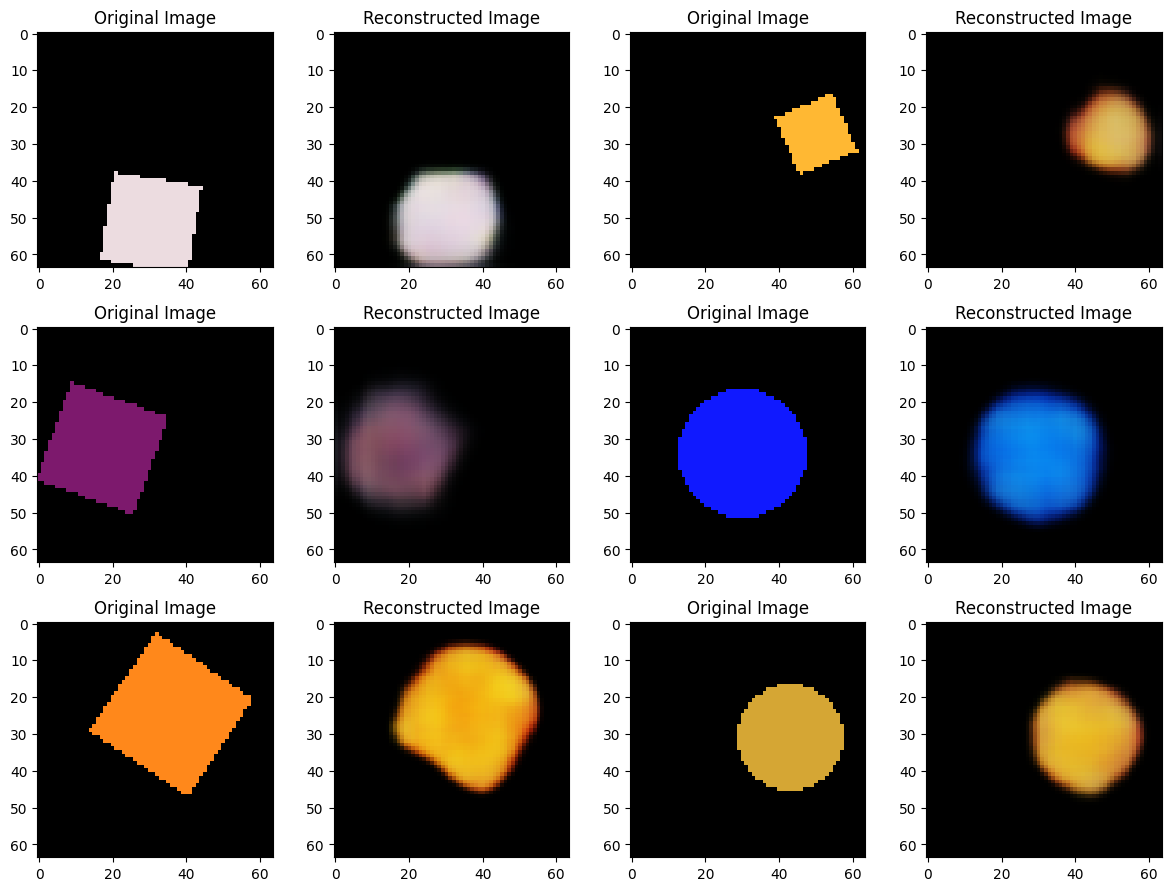

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Dropout(p=0.1, inplace=False)
     (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (5): ReLU()
     (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (7): Dropout(p=0.1, inplace=False)
     (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (9): ReLU()
     (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (11): Dropout(p=0.1, inplace=False)
   )
   (fc1): Linear(in_features=8192, out_features=16, bias=True)
   (fc2): Linear(in_features=16, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')

In [6]:
train_model(embedding_size=16, dropout_rate=0.1)

Number of parameters: 866467


/Users/criyle/project/cse5524/cse5524final/util.py:333: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:334: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.296
Shape Accuracy: 0.738
Combined Accuracy: 0.21


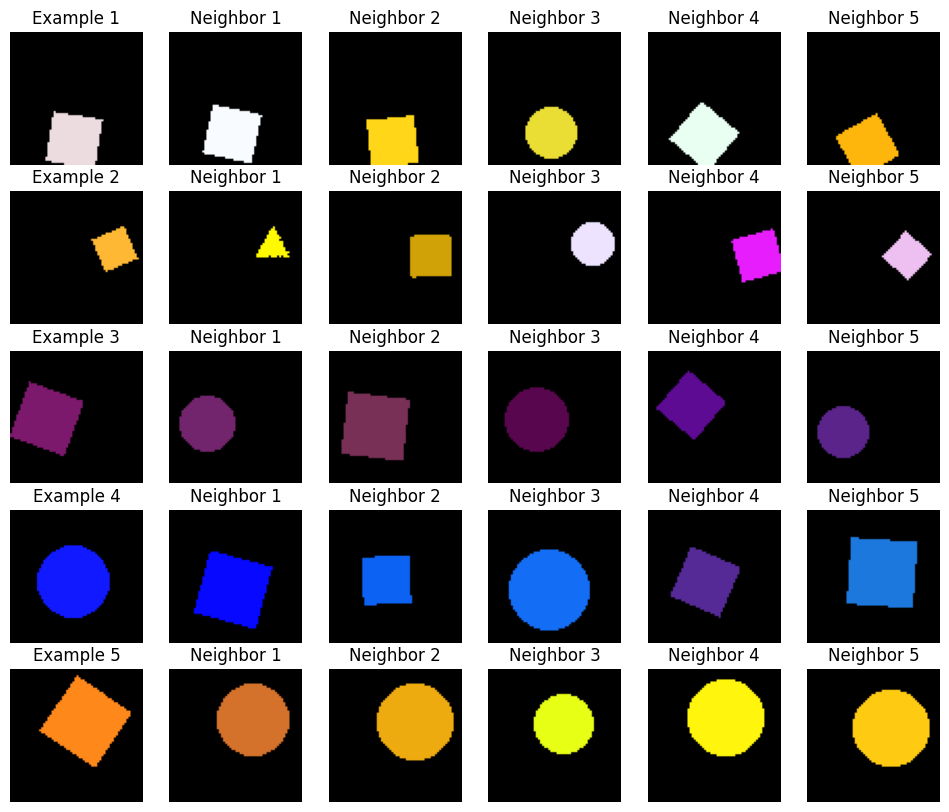

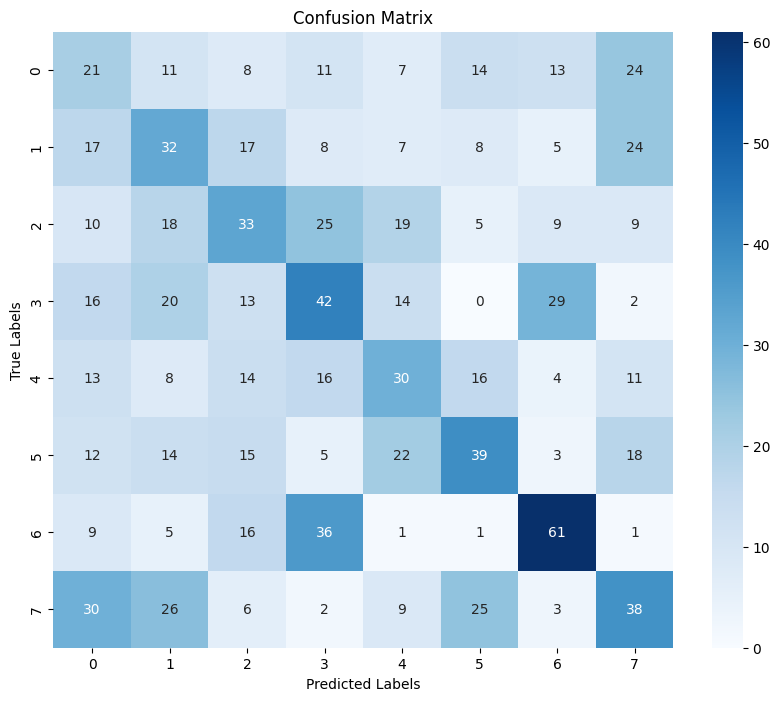

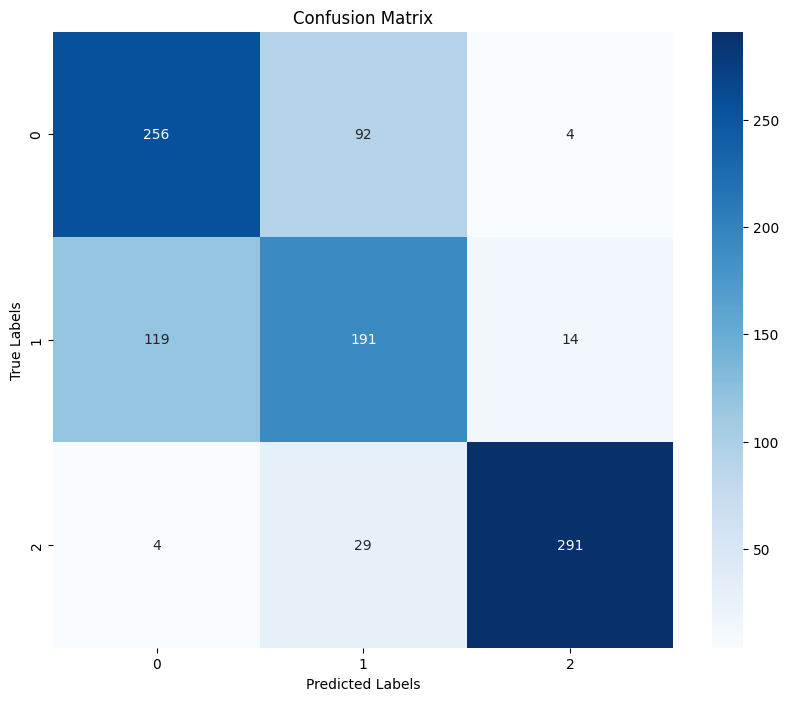

Silhouette Score: -0.15137222409248352
Cluster Purity: 0.2
Normalized Mutual Information (NMI): 0.2665646922818601


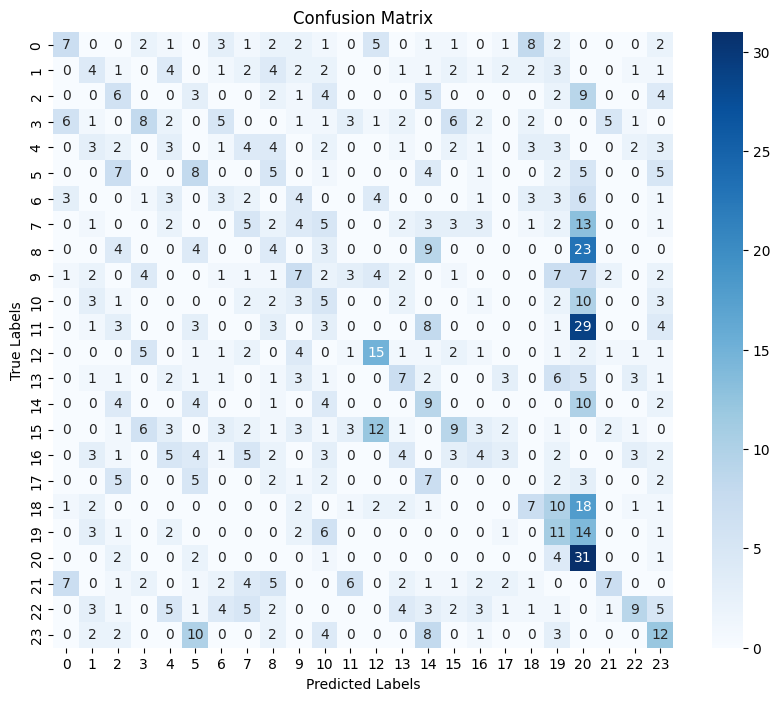

Silhouette Score: -0.11043530702590942
Cluster Purity: 0.259
Normalized Mutual Information (NMI): 0.08770009306170953


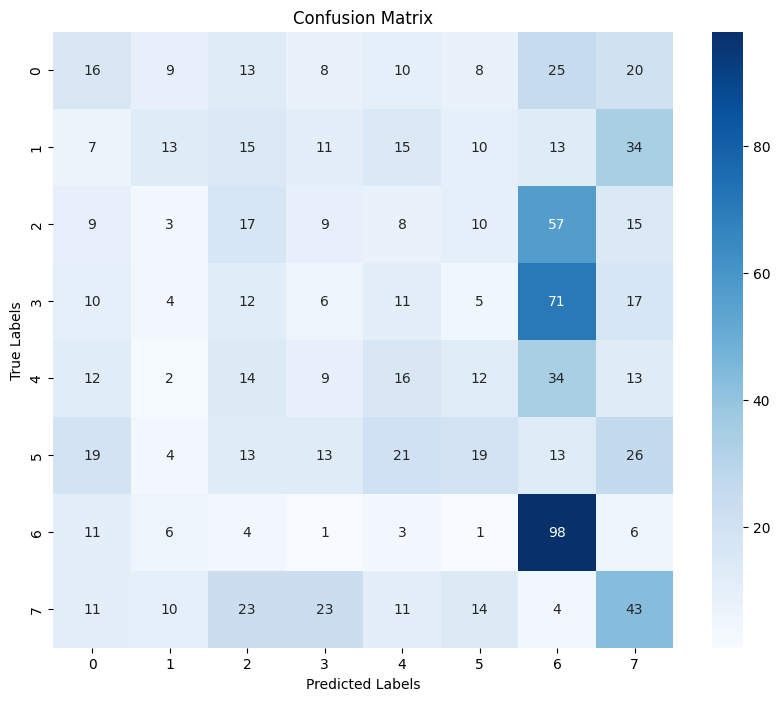

Silhouette Score: 0.01767181046307087
Cluster Purity: 0.476
Normalized Mutual Information (NMI): 0.1639628213310966


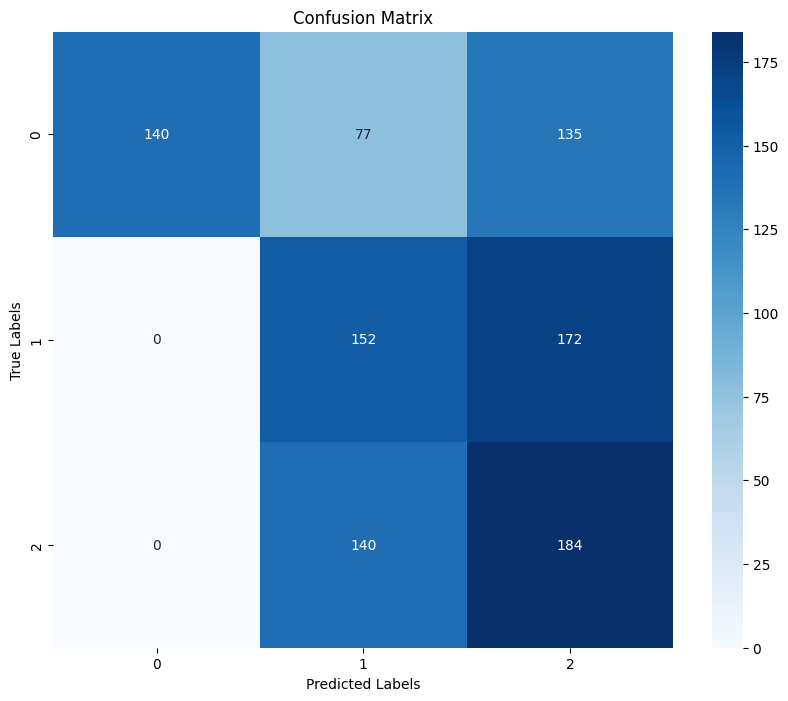

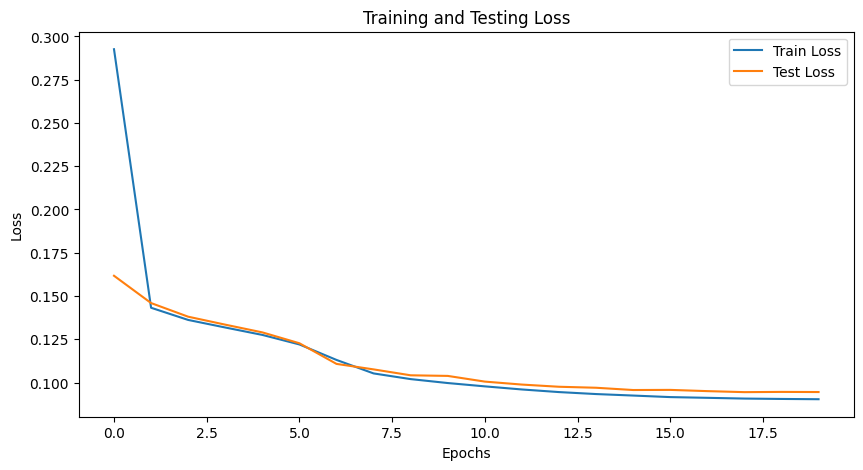

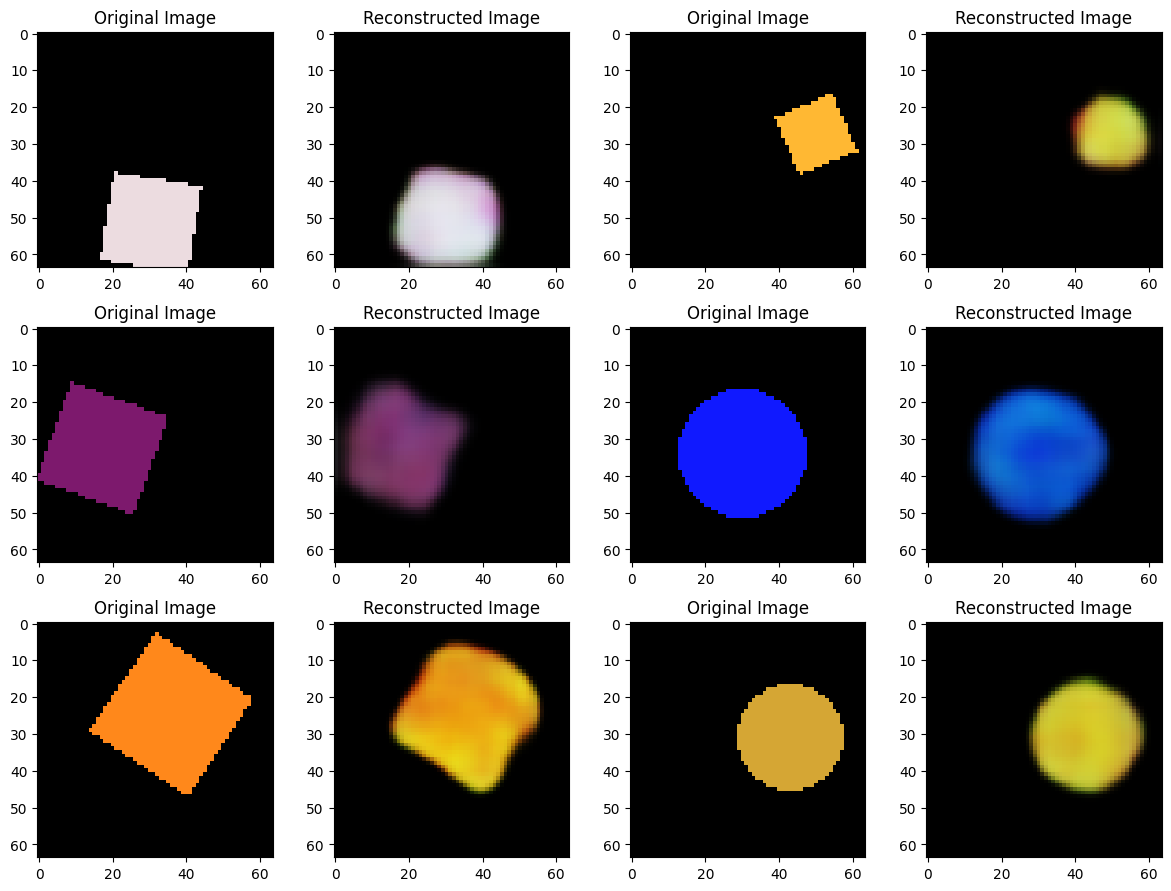

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Dropout(p=0.1, inplace=False)
     (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (5): ReLU()
     (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (7): Dropout(p=0.1, inplace=False)
     (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (9): ReLU()
     (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (11): Dropout(p=0.1, inplace=False)
   )
   (fc1): Linear(in_features=8192, out_features=32, bias=True)
   (fc2): Linear(in_features=32, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')

In [7]:
train_model(embedding_size=32, dropout_rate=0.1)

Number of parameters: 1390787


/Users/criyle/project/cse5524/cse5524final/util.py:333: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:334: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.296
Shape Accuracy: 0.74
Combined Accuracy: 0.211


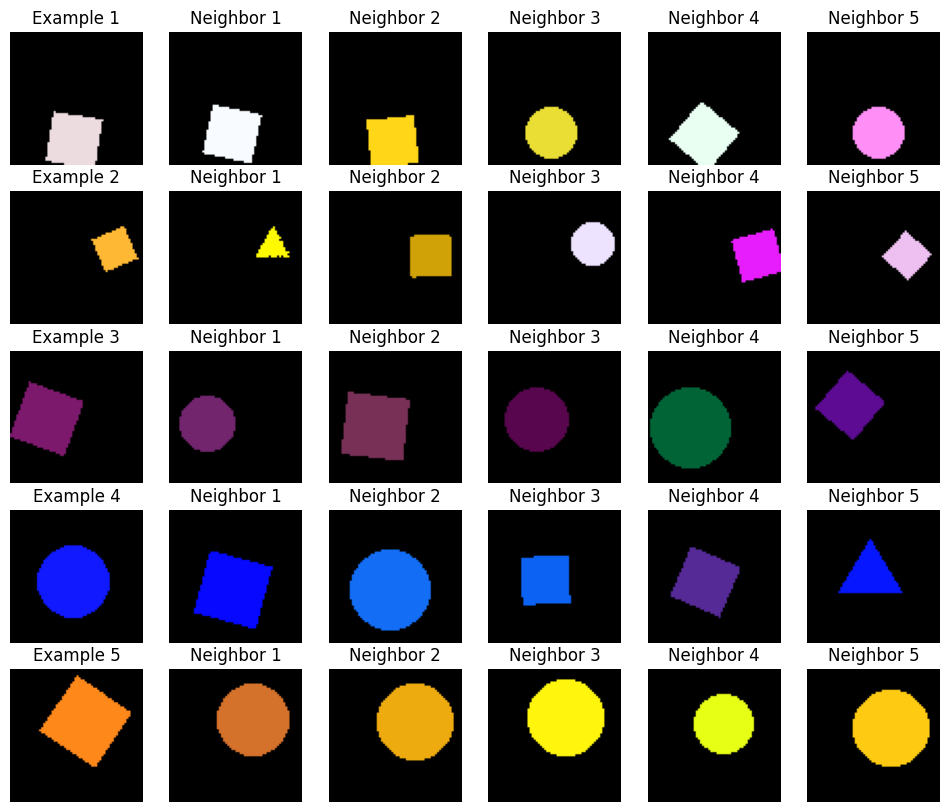

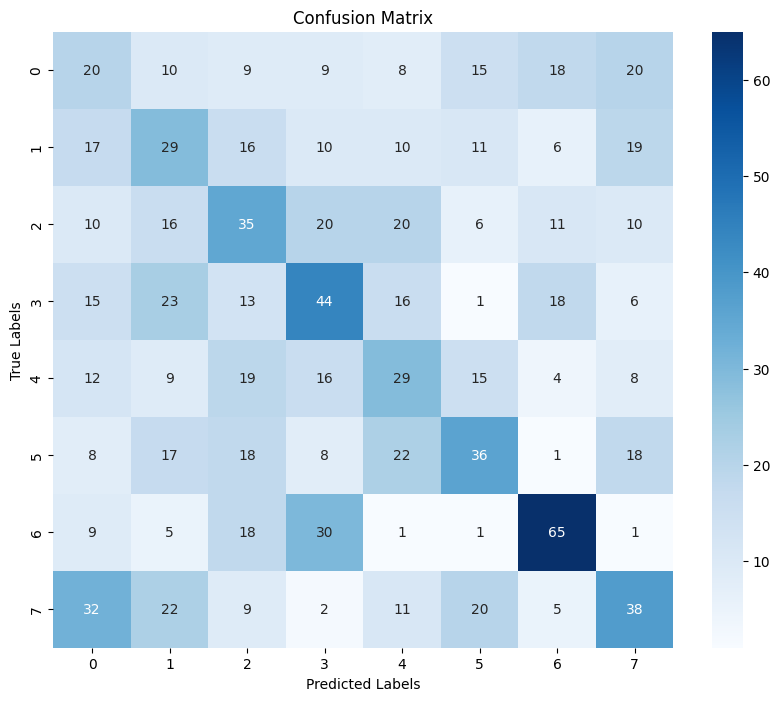

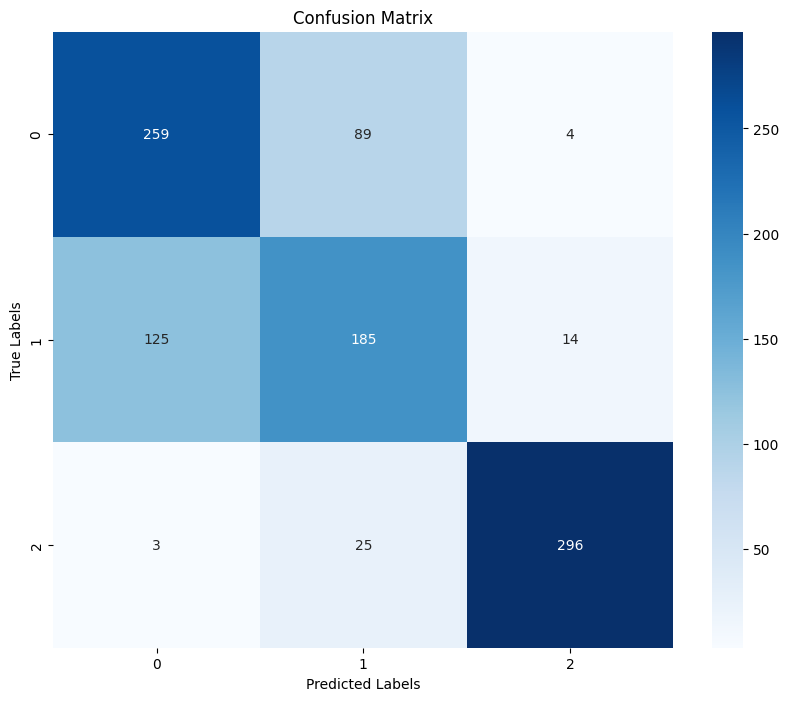

Silhouette Score: -0.14197112619876862
Cluster Purity: 0.209
Normalized Mutual Information (NMI): 0.2674163624641521


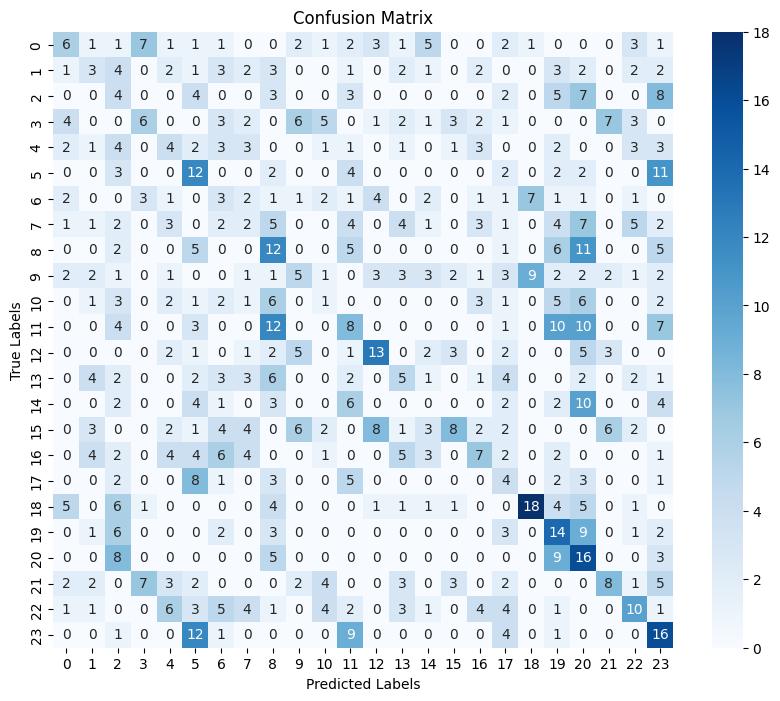

Silhouette Score: -0.09942492842674255
Cluster Purity: 0.224
Normalized Mutual Information (NMI): 0.06446923634500779


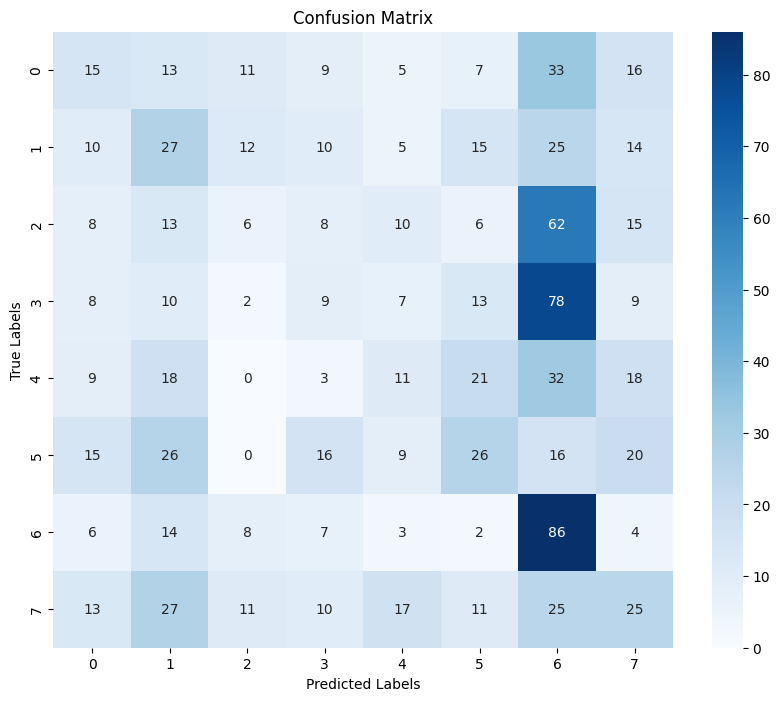

Silhouette Score: 0.02283201366662979
Cluster Purity: 0.513
Normalized Mutual Information (NMI): 0.1721639460479749


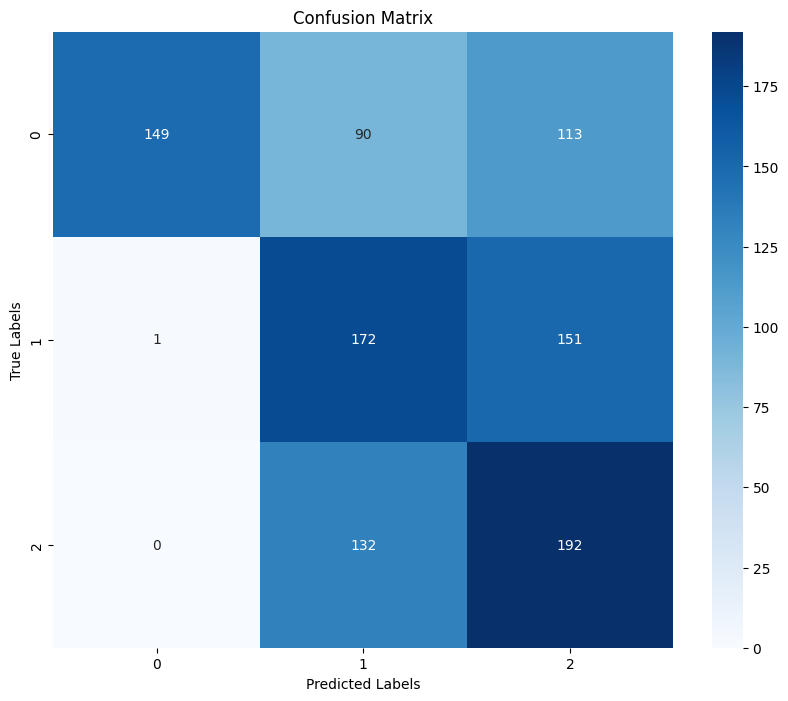

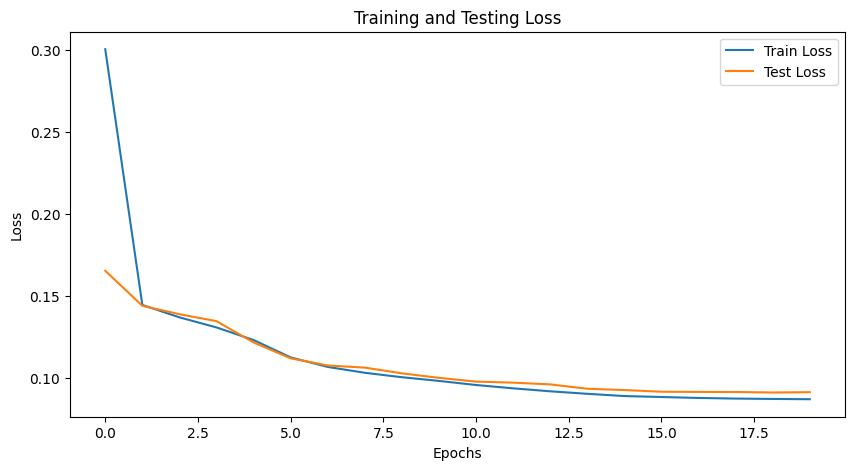

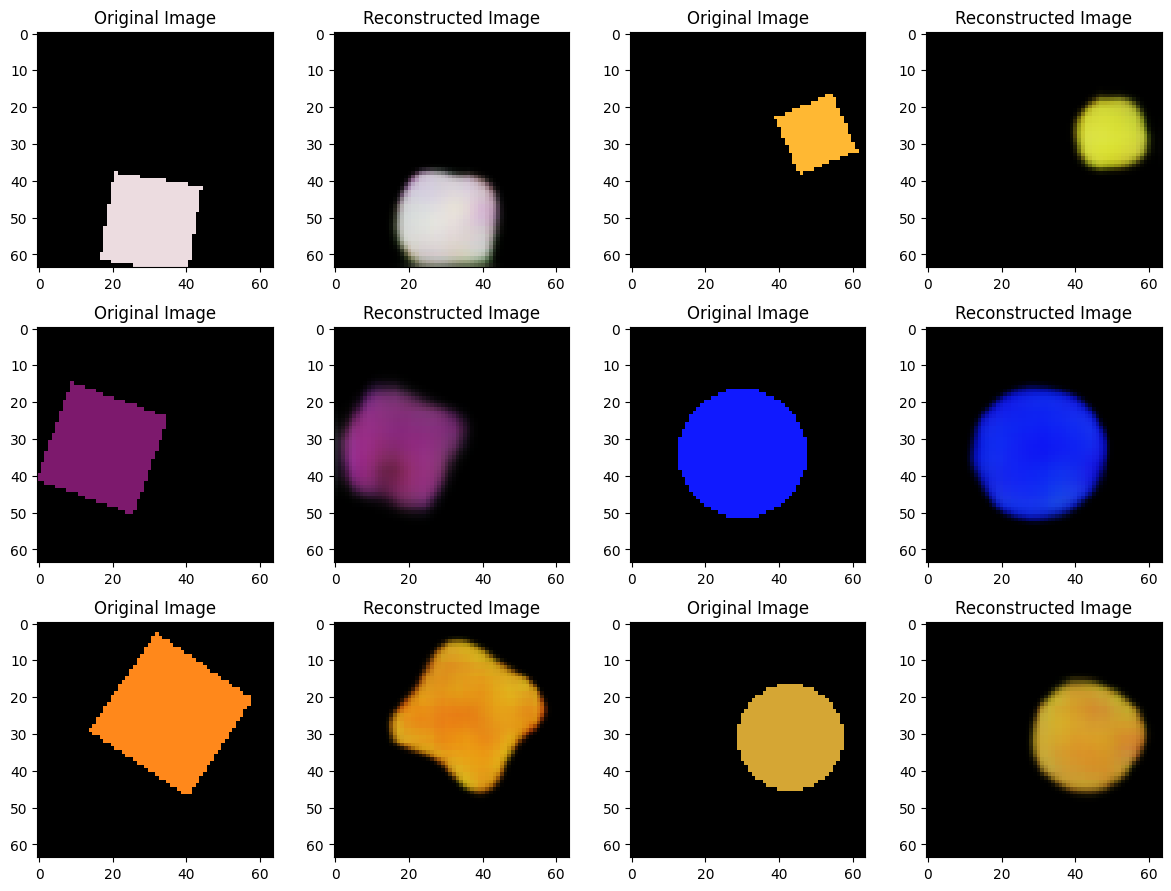

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Dropout(p=0.1, inplace=False)
     (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (5): ReLU()
     (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (7): Dropout(p=0.1, inplace=False)
     (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (9): ReLU()
     (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (11): Dropout(p=0.1, inplace=False)
   )
   (fc1): Linear(in_features=8192, out_features=64, bias=True)
   (fc2): Linear(in_features=64, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')

In [8]:
train_model(embedding_size=64, dropout_rate=0.1)

In [9]:
print(accuracy)

{4: (215, 718, 158), 8: (320, 708, 218), 16: (298, 715, 207), 32: (296, 738, 210), 64: (296, 740, 211)}
